<a href="https://colab.research.google.com/github/jordanbell2357/uscg-nais-data/blob/main/BigQuery/mmsi_368174410.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# @title Setup
from google.colab import auth
from google.cloud import bigquery
from google.colab import data_table

project = 'ais-data-385301' # Project ID inserted based on the query results selected to explore
location = 'US' # Location inserted based on the query results selected to explore
client = bigquery.Client(project=project, location=location)
data_table.enable_dataframe_formatter()
auth.authenticate_user()

## Reference SQL syntax from the original job
Use the ```jobs.query```
[method](https://cloud.google.com/bigquery/docs/reference/rest/v2/jobs/query) to
return the SQL syntax from the job. This can be copied from the output cell
below to edit the query now or in the future. Alternatively, you can use
[this link](https://console.cloud.google.com/bigquery?j=ais-data-385301:US:bquxjob_6e4920c7_18877f73b54)
back to BigQuery to edit the query within the BigQuery user interface.

In [2]:
# Running this code will display the query used to generate your previous job

job = client.get_job('bquxjob_6e4920c7_18877f73b54') # Job ID inserted based on the query results selected to explore
print(job.query)

SELECT * FROM `ais-data-385301.uscg.nais` WHERE MMSI = '368174410' ORDER BY BaseDateTime ASC;


# Result set loaded from BigQuery job as a DataFrame
Query results are referenced from the Job ID ran from BigQuery and the query
does not need to be re-run to explore results. The ```to_dataframe```
[method](https://googleapis.dev/python/bigquery/latest/generated/google.cloud.bigquery.job.QueryJob.html#google.cloud.bigquery.job.QueryJob.to_dataframe)
downloads the results to a Pandas DataFrame by using the BigQuery Storage API.

To edit query syntax, you can do so from the BigQuery SQL editor or in the
```Optional:``` sections below.

In [3]:
# Running this code will read results from your previous job

job = client.get_job('bquxjob_6e4920c7_18877f73b54') # Job ID inserted based on the query results selected to explore
results = job.to_dataframe()

In [5]:
results.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 160025 entries, 0 to 160024
Data columns (total 17 columns):
 #   Column            Non-Null Count   Dtype              
---  ------            --------------   -----              
 0   MMSI              160025 non-null  object             
 1   BaseDateTime      160025 non-null  datetime64[ns, UTC]
 2   LAT               160025 non-null  float64            
 3   LON               160025 non-null  float64            
 4   SOG               160025 non-null  float64            
 5   COG               160025 non-null  float64            
 6   Heading           160025 non-null  float64            
 7   VesselName        160025 non-null  object             
 8   IMO               160025 non-null  object             
 9   CallSign          160025 non-null  object             
 10  VesselType        160025 non-null  object             
 11  Status            160025 non-null  object             
 12  Length            160025 non-null  float64  

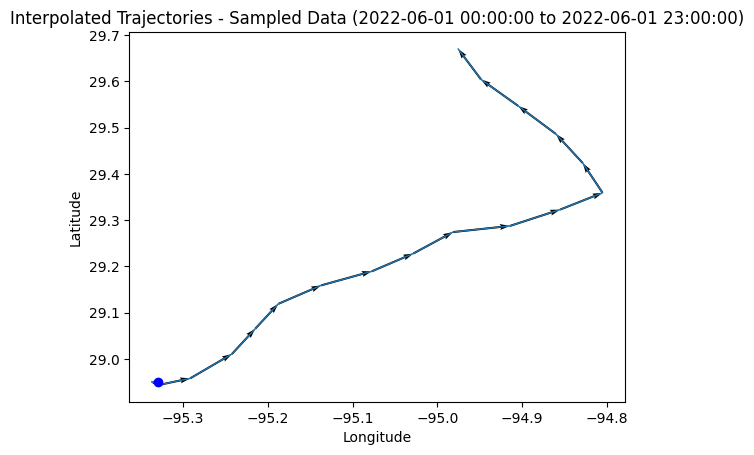

In [6]:
import pandas as pd
import matplotlib.pyplot as plt

# Parameters
start_date = '2022-06-01 00:00:00'  # Include the desired hour
end_date = '2022-06-01 23:00:00'  # Include the desired hour
sampling_rate = '30min'  # Options: '1min', '5min', '10min', '15min', '30min', '1H', '2H', '3H', ...

# Define the DataFrame with desired columns
df = results.copy()

# Set the 'BaseDateTime' column as the DataFrame index
df.set_index('BaseDateTime', inplace=True)

# Apply time cutoff
df = df.loc[start_date:end_date]

# Resample the data to the specified sampling rate
sampled_data = df.resample(sampling_rate).first()

# Interpolate the data for smooth trajectories
interpolated_data = sampled_data.interpolate(method='linear')

# Create a plot of the interpolated trajectories
plt.plot(
    interpolated_data['LON'],
    interpolated_data['LAT'],
    '-',
    linewidth=1
)

# Add a dot at the start of the trajectory
plt.plot(
    interpolated_data['LON'].iloc[0],
    interpolated_data['LAT'].iloc[0],
    'bo'
)

# Add styling with arrows indicating the direction of time
dx = interpolated_data['LON'].diff().shift(-1)
dy = interpolated_data['LAT'].diff().shift(-1)
plt.quiver(
    interpolated_data['LON'],
    interpolated_data['LAT'],
    dx,
    dy,
    angles='xy',
    scale_units='xy',
    scale=1,
    width=0.004,  # Increase the width to make the arrows wider
    color='black'
)

# Customize the plot
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Interpolated Trajectories - Sampled Data ({} to {})'.format(start_date, end_date))

plt.show()

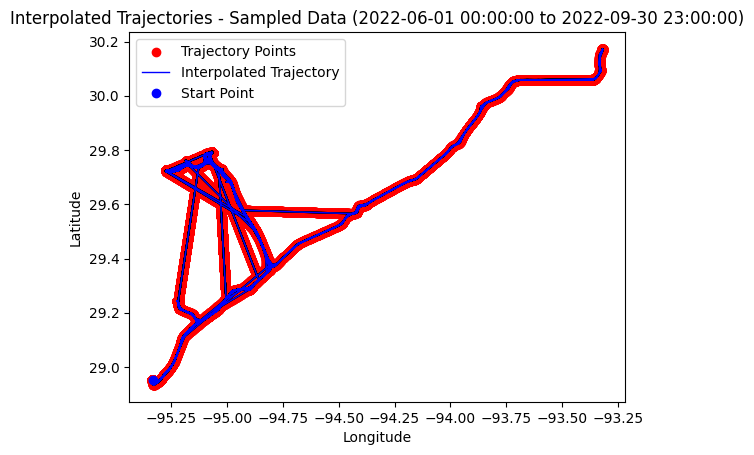

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

df = results.copy()

# Set start and end timestamps for the analysis
start_date = pd.Timestamp('2022-06-01 00:00:00')  # Include the desired hour
end_date = pd.Timestamp('2022-09-30 23:00:00')  # Include the desired hour

sampling_rate = '15min'  # Options: '1min', '5min', '10min', '15min', '30min', '1H', '2H', '3H', ...

# Define the DataFrame with desired columns

# Set the 'BaseDateTime' column as the DataFrame index
df.set_index('BaseDateTime', inplace=True)

# Convert to timezone naive UTC
df.index = df.index.tz_convert('UTC').tz_localize(None)

# Apply time cutoff
df = df.loc[start_date:end_date]

# Resample the data to the specified sampling rate
sampled_data = df.resample(sampling_rate).first()

# Interpolate the data for smooth trajectories
interpolated_data = sampled_data.interpolate(method='linear')

# Convert datetime to numerical values
time_vals = (interpolated_data.index - pd.Timestamp("1970-01-01")) // pd.Timedelta('1s')

# Create an interpolation function for the latitude and longitude coordinates
interp_func = interp1d(
    time_vals,
    interpolated_data[['LAT', 'LON']],
    kind='linear',
    axis=0,
    fill_value='extrapolate'
)

# Generate new time points for finer sampling
new_time_vals = np.arange(time_vals.min(), time_vals.max(), 60)  # 60 seconds for 1-minute frequency

# Interpolate the latitude and longitude coordinates at the new time points
new_coords = interp_func(new_time_vals)

# Convert back to datetime format
new_time = pd.to_datetime(new_time_vals, unit='s')

# Create a scatter plot of the interpolated data
plt.scatter(
    new_coords[:, 1],
    new_coords[:, 0],
    c='red',
    marker='o',
    label='Trajectory Points'
)

# Create a line plot of the interpolated trajectory
plt.plot(
    new_coords[:, 1],
    new_coords[:, 0],
    '-',
    linewidth=1,
    color='blue',
    label='Interpolated Trajectory'
)

# Add a dot at the start of the trajectory
plt.plot(
    new_coords[0, 1],
    new_coords[0, 0],
    'bo',
    label='Start Point'
)

# Compute difference for arrow directions
d_coords = np.diff(new_coords, axis=0)

# Add styling with arrows indicating the direction of time
plt.quiver(
    new_coords[:-1, 1],
    new_coords[:-1, 0],
    d_coords[:, 1],
    d_coords[:, 0],
    angles='xy',
    scale_units='xy',
    scale=1,
    width=0.004,  # Increase the width to make the arrows wider
    color='black'
)

# Customize the plot
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Interpolated Trajectories - Sampled Data ({} to {})'.format(start_date, end_date))
plt.legend()

plt.show()

In [9]:
!pip install h3

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 13.6 MB/s eta 0:00:00


<Axes: >

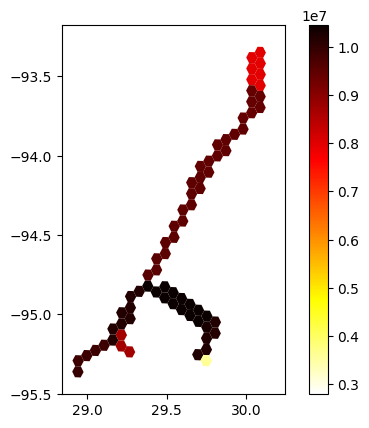

In [10]:
import h3
import geopandas as gpd
from shapely.geometry import Polygon
import numpy as np

df = results.copy()

# h3
resolution_parameter = 6

# Set start and end timestamps for the analysis
start_date = pd.Timestamp('2022-06-01 00:00:00')  # Include the desired hour
end_date = pd.Timestamp('2022-09-30 23:00:00')  # Include the desired hour

df['BaseDateTime'] = pd.to_datetime(df['BaseDateTime']).dt.tz_convert('UTC').dt.tz_localize(None)

# Apply time cutoff
df_filtered = df[(df['BaseDateTime'] >= start_date) & (df['BaseDateTime'] <= end_date)].copy()

# Convert latitude and longitude to H3 grid indices
df_filtered['H3Index'] = df_filtered.apply(lambda row: h3.geo_to_h3(row['LAT'], row['LON'], resolution=resolution_parameter), axis=1)

# Calculate the time spent in each hexagon based on distances between consecutive timestamps
hexagon_data = []
for hex_id, hex_group in df_filtered.groupby('H3Index'):
    hex_group = hex_group.sort_values('BaseDateTime')
    hex_group['TimeDiff'] = hex_group['BaseDateTime'].diff().fillna(pd.Timedelta(seconds=0))
    hex_group['TimeDiff'] = hex_group['TimeDiff'].apply(lambda x: x.total_seconds())
    total_time = np.sum(hex_group['TimeDiff'])
    hexagon_data.append({'H3Index': hex_id, 'Time': total_time})

# Create a GeoDataFrame with the time spent data
hexagon_data = pd.DataFrame(hexagon_data)
geometry = hexagon_data['H3Index'].apply(lambda h: Polygon(h3.h3_to_geo_boundary(h, geo_json=False)))
density_data = gpd.GeoDataFrame(hexagon_data, geometry=geometry)

# Visualize the density map
density_data.plot(column='Time', cmap='hot_r', legend=True)


<Axes: >

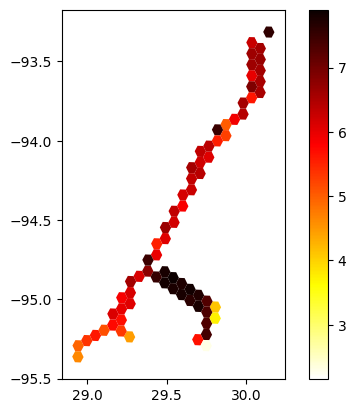

In [12]:
import h3
import geopandas as gpd
from shapely.geometry import Polygon
import numpy as np

df = results.copy()

# h3
resolution_parameter = 6

# Set start and end timestamps for the analysis
start_date = pd.Timestamp('2022-06-01 00:00:00')  # Include the desired hour
end_date = pd.Timestamp('2022-09-30 23:00:00')  # Include the desired hour

df['BaseDateTime'] = pd.to_datetime(df['BaseDateTime']).dt.tz_convert('UTC').dt.tz_localize(None)

# Apply time cutoff
df_filtered = df[(df['BaseDateTime'] >= start_date) & (df['BaseDateTime'] <= end_date)].copy()

# Convert latitude and longitude to H3 grid indices
df_filtered['H3Index'] = df_filtered.apply(lambda row: h3.geo_to_h3(row['LAT'], row['LON'], resolution=resolution_parameter), axis=1)

# Calculate the duration weighted mean SOG in each hexagon
hexagon_data = []
for hex_id, hex_group in df_filtered.groupby('H3Index'):
    hex_group = hex_group.sort_values('BaseDateTime')
    hex_group['TimeDiff'] = hex_group['BaseDateTime'].diff().fillna(pd.Timedelta(seconds=0))
    hex_group['TimeDiff'] = hex_group['TimeDiff'].apply(lambda x: x.total_seconds())
    total_duration = np.sum(hex_group['TimeDiff'])
    weighted_mean_sog = np.average(hex_group['SOG'], weights=hex_group['TimeDiff'])  # Duration weighted mean SOG
    hexagon_data.append({'H3Index': hex_id, 'WeightedMeanSOG': weighted_mean_sog, 'TotalDuration': total_duration})

# Create a GeoDataFrame with the weighted mean SOG and total duration data
hexagon_data = pd.DataFrame(hexagon_data)
geometry = hexagon_data['H3Index'].apply(lambda h: Polygon(h3.h3_to_geo_boundary(h, geo_json=False)))
density_data = gpd.GeoDataFrame(hexagon_data, geometry=geometry)

# Visualize the density map
density_data.plot(column='WeightedMeanSOG', cmap='hot_r', legend=True)


<Axes: >

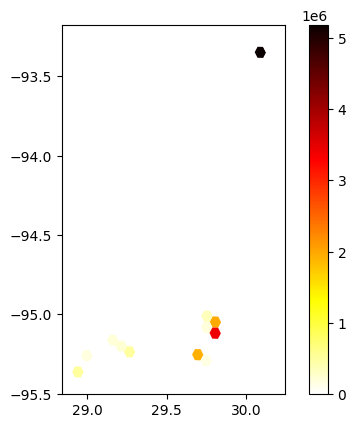

In [21]:
import h3
import geopandas as gpd
from shapely.geometry import Polygon
import numpy as np

df = results.copy()

# h3
resolution_parameter = 6

# Set start and end timestamps for the analysis
start_date = pd.Timestamp('2022-06-01 00:00:00')  # Include the desired hour
end_date = pd.Timestamp('2022-09-30 23:00:00')  # Include the desired hour

# Set SOG cutoff parameter
sog_cutoff = 2  # Set the desired SOG cutoff value

df['BaseDateTime'] = pd.to_datetime(df['BaseDateTime']).dt.tz_convert('UTC').dt.tz_localize(None)

# Apply time cutoff
df_filtered = df[(df['BaseDateTime'] >= start_date) & (df['BaseDateTime'] <= end_date)].copy()

# Convert latitude and longitude to H3 grid indices
df_filtered['H3Index'] = df_filtered.apply(lambda row: h3.geo_to_h3(row['LAT'], row['LON'], resolution=resolution_parameter), axis=1)

# Calculate the duration spent in each hexagon when SOG >= cutoff
hexagon_data = []
for hex_id, hex_group in df_filtered.groupby('H3Index'):
    hex_group = hex_group.sort_values('BaseDateTime')
    hex_group['TimeDiff'] = hex_group['BaseDateTime'].diff().fillna(pd.Timedelta(seconds=0))
    hex_group['TimeDiff'] = hex_group['TimeDiff'].apply(lambda x: x.total_seconds())
    hex_group_filtered = hex_group[hex_group['SOG'] <= sog_cutoff]
    total_duration = np.sum(hex_group_filtered['TimeDiff'])
    hexagon_data.append({'H3Index': hex_id, 'TotalDuration': total_duration})

# Create a GeoDataFrame with the total duration data
hexagon_data = pd.DataFrame(hexagon_data)
geometry = hexagon_data['H3Index'].apply(lambda h: Polygon(h3.h3_to_geo_boundary(h, geo_json=False)))
density_data = gpd.GeoDataFrame(hexagon_data, geometry=geometry)

# Visualize the density map
density_data.plot(column='TotalDuration', cmap='hot_r', legend=True)